In [5]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import sys
import warnings
sys.path.append('../')
from spectral_extraction.spectra_2d import spectra_2d
from spectral_extraction.ploting import plot2d_spectra
from spectral_extraction.fitting import make_fit,paralel_fit
from spectral_extraction.spectra_extraction_results import spectral_extraction_results_handler
from spectral_extraction.utils import guess_picks_image,find_signal
import pickle

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
image_path ="J1036-8544_MAPPED_SCI_MOS.fits"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits")#"J1036-8544_MAPPED_SCI_MOS.fits"#"J0030-3358_MAPPED_SCI_MOS.fits"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits")#"J0030-3358_MAPPED_SCI_MOS.fits"#"J1036-8544_MAPPED_SCI_MOS.fits"#"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits"),"J0030-3358_MAPPED_SCI_MOS.fits" #"
Image2d=spectra_2d(image_path,center_cut = None,size_cut=55,verbose=True)

J1036-8544_MAPPED_SCI_MOS.fits
mad = 0.031202499
cut center 471 and cut size 55


#### Check the cutout for any case

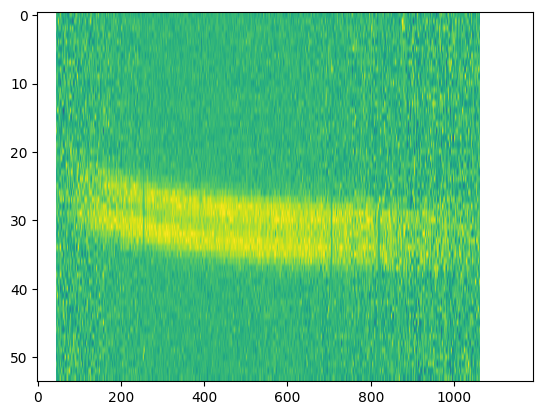

In [26]:
plt.imshow(Image2d.data2d/Image2d.data2d.max(axis=0),aspect="auto")

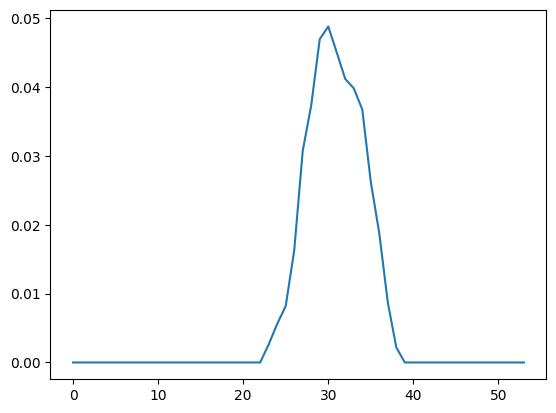

In [21]:
plt.plot(Image2d.stacked_median)

## The modeling 

In [8]:
image=Image2d.data2d
picks=np.array([guess_picks_image(i,2) for i in image.T])
guess_center = np.nanmedian(picks)
guess_separation = np.nanmean(picks[:,1:]) - np.nanmedian(picks) 
print(guess_center,guess_separation) # keep the sign in the separation to be consistent with the code

31.0 -3.0999020568070534


In [9]:
# 1.7233075782889542
full_result_step_1 = paralel_fit(image,2,initial_center=31.0,initial_separation=[-3.0999020568070534],pixel_limit=[],bound_sigma=[2],distribution="gaussian",mask_list=[],\
                          param_value=None,param_limit=None,param_fix=None)# at the moment the mask only work in the 

The code will be executed in 16 core using 2 sources an a gaussian distribution


DONE:   0%|          | 0/1191 [00:00<?, ?it/s]

mean value for value_center_1 if 32.347092959110476


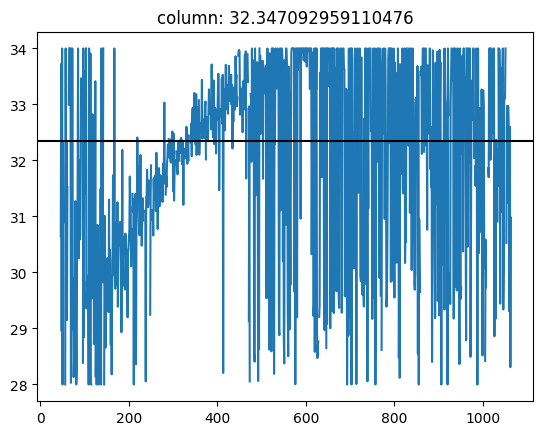

mean value for value_center_2 if 28.247896548451273


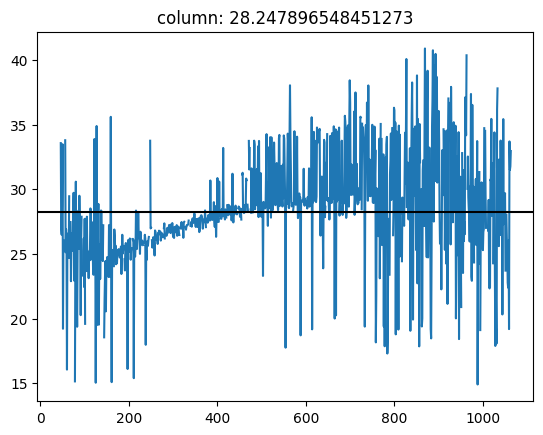

mean value for value_separation_2 if -4.874143036474134


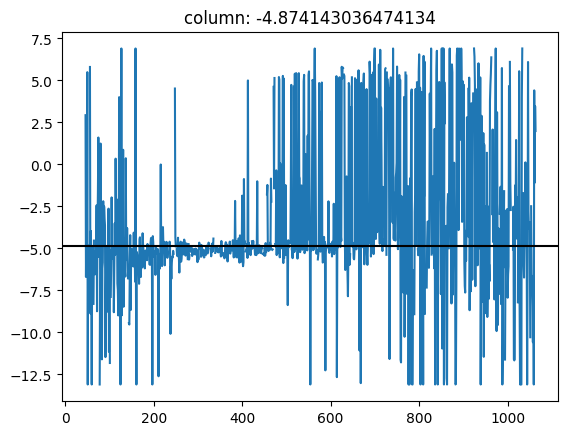

mean value for value_sigma_2 if 1.840798167096402


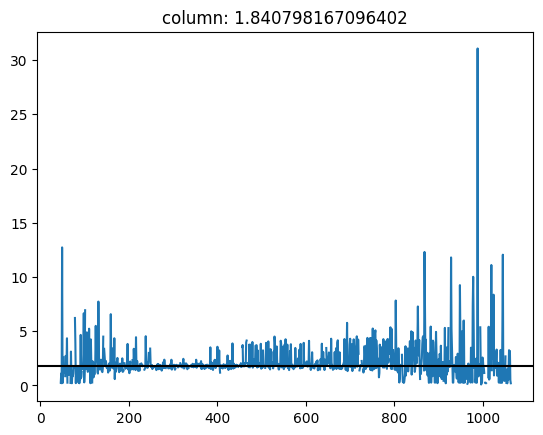

In [10]:
serh_1=spectral_extraction_results_handler(full_result_step_1)
median_c1=serh_1.plot_column("value_center_1")
median_c2=serh_1.plot_column("value_center_2")
median_s2=serh_1.plot_column("value_separation_2")
median_sigma2=serh_1.plot_column("value_sigma_2")

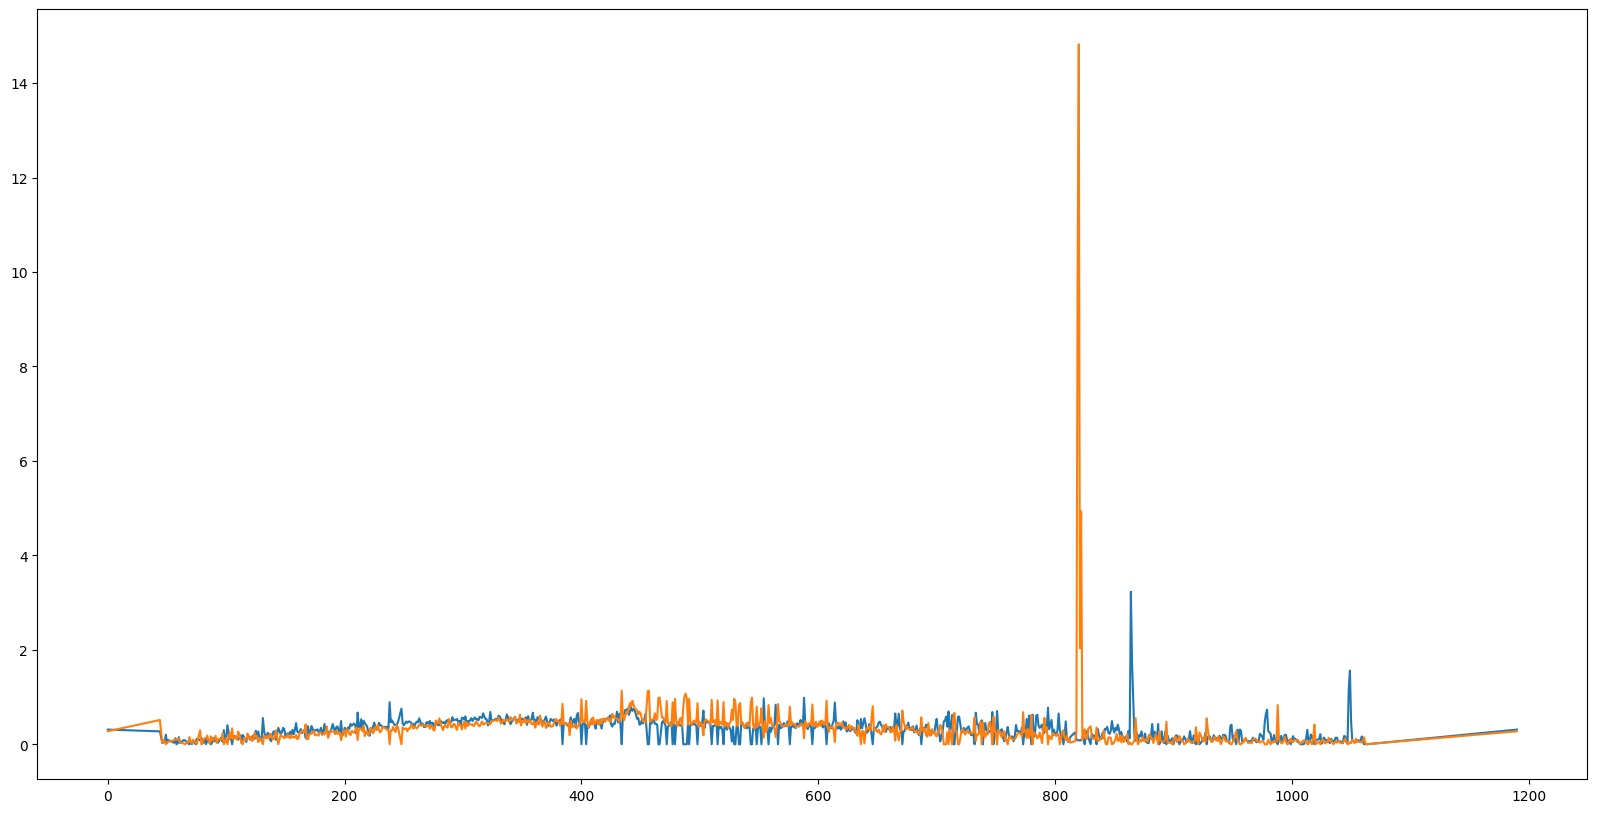

In [11]:
flux_1 = serh_1.spectras1d['flux_1']
flux_2 = serh_1.spectras1d['flux_2']
plt.figure(figsize=(20,10))
plt.plot(flux_1)
plt.plot(flux_2)

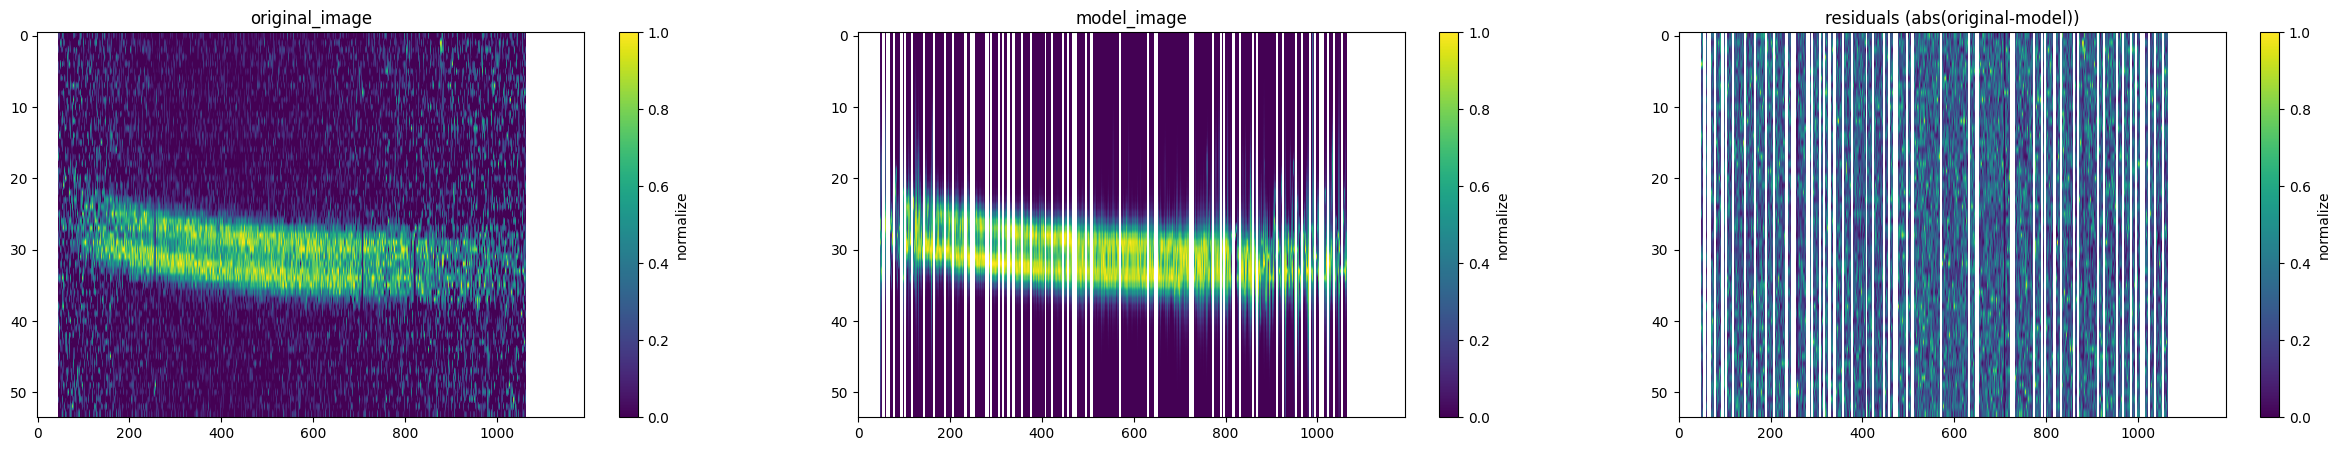

In [12]:
serh_1.plot_2d_image_residuals()

#### Now, as you can see, the spectra don't look good, so a second step is required; in this second step, we can use the median values of the previous step and add some constraints to avoid non logical results, has example change the order of the central position

In [13]:
full_result_2 = paralel_fit(image,2,initial_center=median_c1,initial_separation=[median_s2],pixel_limit=[],bound_sigma=[2],distribution="gaussian",mask_list=[],\
                          param_value={"sigma_1":median_sigma2},param_limit={"separation_2":[-10,-0.01],"sigma_1":[median_sigma2*0.85,median_sigma2*1.15]})# 
#results from this are  {"image":image_copy.T,"full_fit":full_fit,"normalize_matrix":normalize_matrix,"num_source":num_source,"distribution":kwargs["distribution"],"mask":mask,"original_image":image}

The code will be executed in 16 core using 2 sources an a gaussian distribution


DONE:   0%|          | 0/1191 [00:00<?, ?it/s]

### save your results could be a good idea to do that 

In [14]:

with open('my_model_extraction.pickle', 'wb') as handle:
    pickle.dump(full_result_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('my_model_extraction.pickle', 'rb') as handle:
    saved_model = pickle.load(handle)


### pre save

In [15]:
serh_2=spectral_extraction_results_handler(full_result_2,conditions={"min":{"rsquared":0.0},"max":{"flux_1":np.percentile(flux_1,99.0),"flux_2":np.percentile(flux_2,99.0)}},header=Image2d.header) 

mean value for value_center_1 if 33.44220566517783


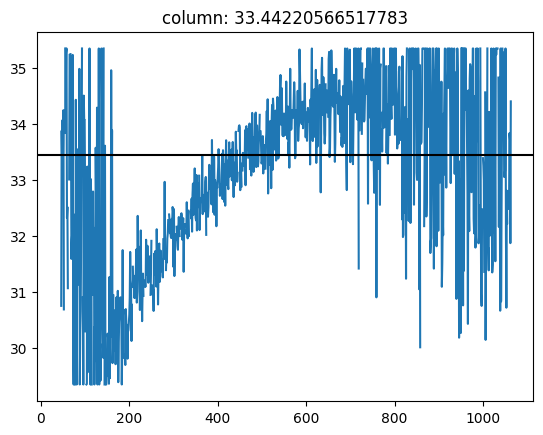

mean value for value_center_2 if 28.2428297426493


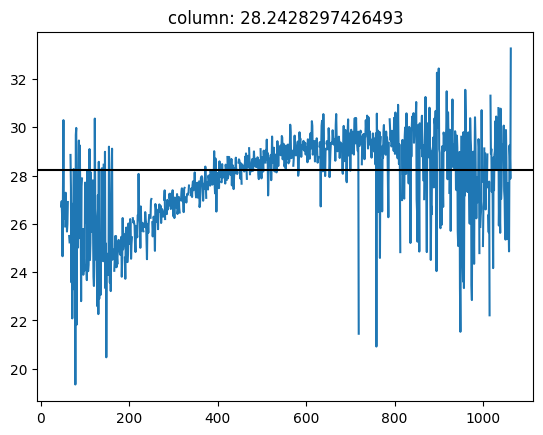

mean value for value_separation_2 if -5.169389248191455


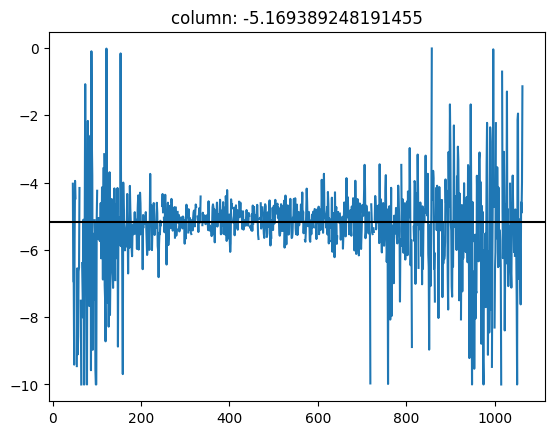

mean value for value_sigma_2 if 1.752514392980877


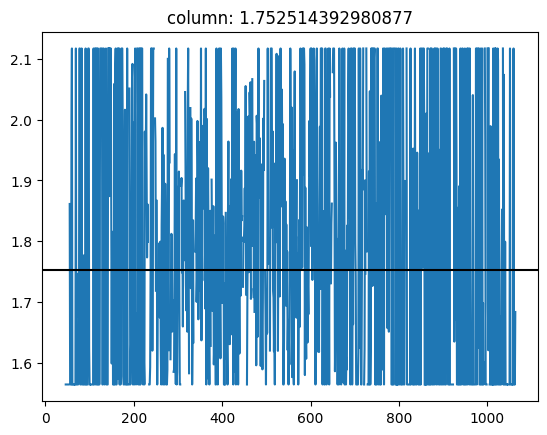

In [16]:
median_c1=serh_2.plot_column("value_center_1")
median_c2=serh_2.plot_column("value_center_2")
median_s2=serh_2.plot_column("value_separation_2")
median_sigma2=serh_2.plot_column("value_sigma_2")

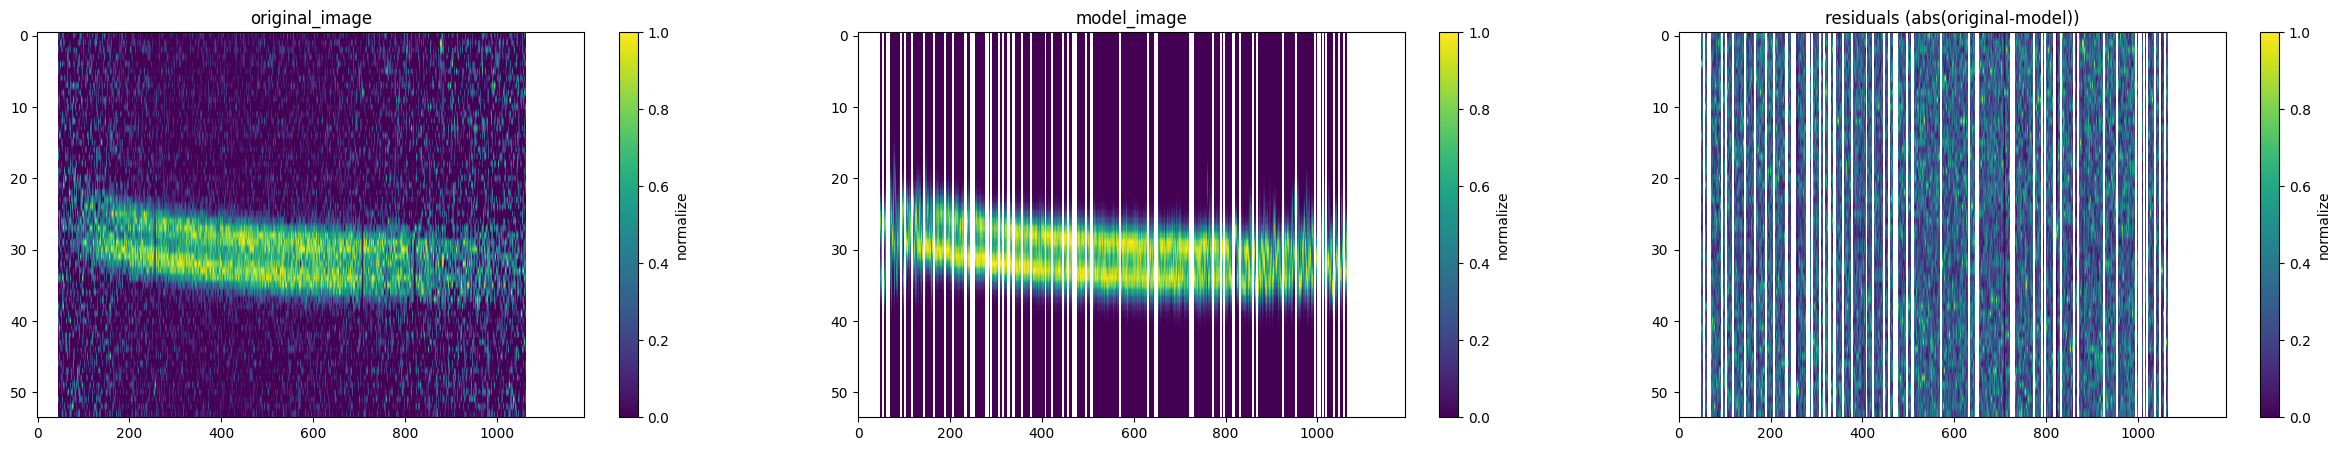

In [17]:
serh_2.plot_2d_image_residuals()

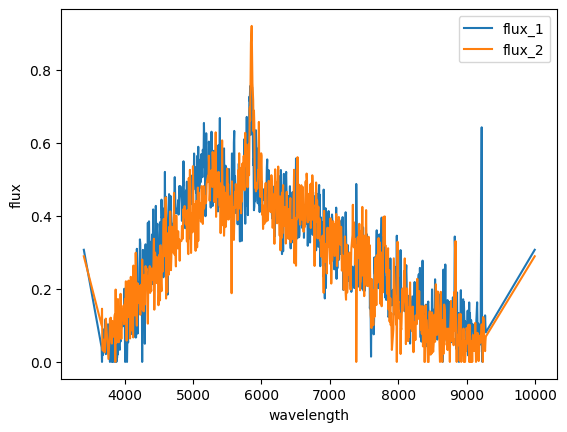

In [18]:
serh_2.plot_spectra()

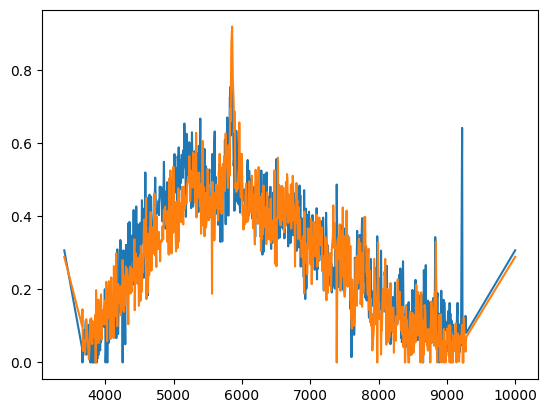

In [19]:
plt.plot(serh_2.cleaned_panda["wavelength"],serh_2.cleaned_panda["flux_1"])
plt.plot(serh_2.cleaned_panda["wavelength"],serh_2.cleaned_panda["flux_2"])

#### How to save "spectral_extraction_results_handler" in a efficent way is not done yet but sooner